#Generating plots for paper

This notebook generates all plots related to Experiment 1 in the paper (called experiment_13 in code).

I fit a tanh model to performance as a function of blur level.

In [69]:
import os
import pickle
import pystan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import data_helpers as helpers
import yaml
from scipy.stats import spearmanr

# put figs together using svgutils (see http://neuroscience.telenczuk.pl/?p=331)
import svgutils.transform as sg

%matplotlib inline

# set some styles we like:
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("paper")
# sns.set_palette("deep")


# set up the figure path:
top_dir = helpers.project_directory()
fig_dir = os.path.join(top_dir, 'figures')

experiment_num = 13
model_name = 'tanh3'

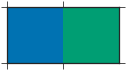

In [70]:
# color palette we like:
with open('plot_palette.yaml', 'r') as f:
    params = yaml.load(f)

pal = sns.color_palette(params['pal'])
pal = sns.color_palette('colorblind', 2)
sns.palplot(pal)

In [71]:
# load unprocessed data, determine eye movement discarding:
dat = pd.read_csv(os.path.join(top_dir, 'results', 
                               ('experiment-' + str(experiment_num)), 
                               'all_data.csv'), index_col=False)
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6100 entries, 0 to 6099
Data columns (total 22 columns):
surround_cond    6100 non-null object
oddball          6100 non-null int64
im_code          6100 non-null object
target_loc       6100 non-null int64
jitter_1         6100 non-null float64
jitter_2         6100 non-null float64
jitter_3         6100 non-null float64
subj             6100 non-null object
session          6100 non-null int64
eccent           6100 non-null int64
patch_size_px    6100 non-null int64
size             6100 non-null float64
blur_sigma       6100 non-null float64
test_location    6100 non-null object
rand_seed        6100 non-null float64
trial            6100 non-null int64
response         6100 non-null object
rt               6084 non-null float64
correct          6084 non-null float64
eye_invalid      6096 non-null float64
eye_sd_deg       6051 non-null float64
time_invalid     6096 non-null float64
dtypes: float64(11), int64(6), object(5)
memory usag

In [72]:
dat.groupby(['subj']).eye_invalid.sum()

subj
S1       1
S10     15
S4     132
Name: eye_invalid, dtype: float64

In [73]:
(dat.groupby(['subj']).eye_invalid.sum() / dat.groupby(['subj']).eye_invalid.size()) * 100

subj
S1     0.050000
S10    0.652174
S4     7.333333
dtype: float64

In [74]:
dat.time_invalid.sum()

45.0

In [75]:
dat.time_invalid.sum() / dat.time_invalid.size

0.0073770491803278691

In [76]:
processed = helpers.experiment_13_data_ready_for_analysis(dat)
processed.groupby(['subj']).size()

/Users/tomwallis/miniconda3/envs/default/lib/python3.4/site-packages/pandas/core/frame.py:2524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/Users/tomwallis/miniconda3/envs/default/lib/python3.4/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tomwallis/miniconda3/envs/default/lib/python3.4/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the

subj
S1     1999
S10    2285
S4     1668
dtype: int64

In [77]:
processed.groupby(['subj', 'patch_size', 'surround', 'blur_sigma']).size()

subj  patch_size  surround  blur_sigma
S1    0.74        blank     1.0           100
                            3.0           100
                            5.0           100
                            8.0           100
                            16.0          100
                  surround  1.0           100
                            3.0           100
                            5.0           100
                            8.0           100
                            16.0          100
      5.95        blank     1.0           100
                            3.0           100
                            5.0           100
                            8.0           100
                            16.0           99
                  surround  1.0           100
                            3.0           100
                            5.0           100
                            8.0           100
                            16.0          100
S10   0.74        blank     1.0          

In [78]:
# load data from fit:
with open (os.path.join(top_dir, 'results', ('experiment-' + str(experiment_num)), 
                        ('expt_' + str(experiment_num) + '_' + 
                         model_name + '_full_model_fit.pkl')), 'rb') as f:
    stan_model, fit, plot_df, param_df, pop_param_df = pickle.load(f)

In [79]:
# print(fit)

In [80]:
# load image data:
im_dat = pd.read_csv(os.path.join(top_dir, 'stimuli', 
                                  ('experiment-' + str(experiment_num)),
                                  'final_ims',
                                  'patch_info.csv'), index_col=False)

# get stats for image rms before normalisation:
im_dat['source_rms'].describe()              

count    200.000000
mean       0.553071
std        0.195379
min        0.070866
25%        0.409088
50%        0.525802
75%        0.647867
max        1.195773
Name: source_rms, dtype: float64

# All subject data with model fits

In [81]:
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118861 entries, 0 to 118860
Data columns (total 14 columns):
blur_sigma     118861 non-null float64
ci_max         61 non-null float64
ci_min         61 non-null float64
error_max      61 non-null float64
error_min      61 non-null float64
n_successes    61 non-null float64
n_trials       61 non-null float64
patch_size     118861 non-null float64
prop_corr      61 non-null float64
sample         118800 non-null float64
subj           118861 non-null object
subj_num       118861 non-null int64
surround       118861 non-null object
yhat           118800 non-null float64
dtypes: float64(11), int64(1), object(2)
memory usage: 13.6+ MB


In [82]:
def plot_chance(*args, **kwargs):
    data = kwargs.pop('data')
    plt.plot((0, 18), (0.33, 0.33), ls='--', color='0.7')
    
def plot_preds(*args, **kwargs):
    data = kwargs.pop('data')
    x_col, y_col, sample_col = args
    for i in range(n_samples):
        x = data.loc[data[sample_col]==i, x_col]
        y = data.loc[data[sample_col]==i, y_col]
        kwargs['marker'] = None
        plt.plot(x, y, **kwargs)

def plot_errors(*args, **kwargs):
    data = kwargs.pop('data')
    x_col, y_col, mask_on = args
    mask = np.isnan(data[mask_on])    
    errors = np.vstack([data.loc[mask, 'error_min'], 
                        data.loc[mask, 'error_max']])

    plt.errorbar(data.loc[mask, x_col], 
                 data.loc[mask, y_col], 
                 yerr=errors,
                 **kwargs);        

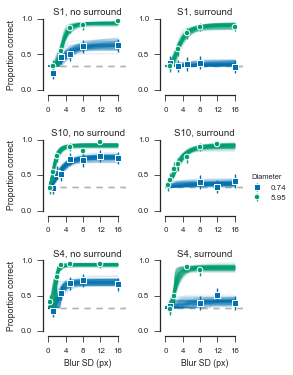

In [83]:
# plot:
n_samples = 100

g = sns.FacetGrid(plot_df, col='surround', row='subj', hue='patch_size', hue_kws={'marker': ['s', 'o']},
                  dropna=False,
                  palette=pal,
                  size=3.5/2)
g.map_dataframe(plot_chance)
g.map_dataframe(plot_preds, 'blur_sigma', 'yhat', 'sample', 
                alpha=0.1)
g.map_dataframe(plot_errors, 'blur_sigma', 'prop_corr', 'yhat',
                linestyle='none', 
                mec='w', mew=1, capsize=0)
g.set_axis_labels('Blur SD (px)', 'Proportion correct')
g.set(xticks=np.linspace(0, 16, num=5), yticks=np.linspace(0, 1, num=3))
g.add_legend(title='Diameter')


# default facet titles:
# for ax in g.axes.flat:
#     print(ax.get_title())
# subj = S1 | surround = blank
# subj = S1 | surround = surround
# subj = S10 | surround = blank
# subj = S10 | surround = surround
# subj = S4 | surround = blank
# subj = S4 | surround = surround

# set shorter titles for facets:
titles = ["S1, no surround",
          "S1, surround",
          "S10, no surround",
          "S10, surround",          
          "S4, no surround",
          "S4, surround"]

for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

g.fig.subplots_adjust(wspace=0.5, hspace=0.7)
sns.despine(offset=5, trim=True);

In [84]:
g.fig.set_figwidth(3.5)
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_observer_fits.pdf'), bbox_inches='tight')

# Parameter posteriors (multipanel plot)

## Critical stim level

In [85]:
# melt this into a tidy frame:
melted = pd.melt(param_df, id_vars=['subj','surround', 'patch_size', 'sample'],
                 var_name='param',
                 value_name='value')
melted.head()

,subj,surround,patch_size,sample,param,value
0,S1,blank,0.74,0,alpha,2.094182
1,S10,blank,0.74,0,alpha,2.922146
2,S4,blank,0.74,0,alpha,2.374117
3,S1,surround,0.74,0,alpha,0.828849
4,S10,surround,0.74,0,alpha,0.564715


In [86]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288000 entries, 0 to 287999
Data columns (total 6 columns):
subj          288000 non-null object
surround      288000 non-null object
patch_size    288000 non-null float64
sample        288000 non-null int64
param         288000 non-null object
value         288000 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 15.4+ MB


In [87]:
np.unique(melted['param'])

array(['alpha', 'beta', 'critical_scale', 'prior_alpha', 'prior_beta',
       'prior_critical_scale'], dtype=object)

### compute numerical values for text

In [88]:
melted.loc[melted['param']=='critical_scale', :].groupby(['subj', 'patch_size', 'surround']).median()

sample     value
subj patch_size surround                  
S1   0.74       blank     1999.5  0.730117
                surround  1999.5  1.189266
     5.95       blank     1999.5  1.614004
                surround  1999.5  0.763979
S10  0.74       blank     1999.5  0.053248
                surround  1999.5  0.065542
     5.95       blank     1999.5  0.060345
                surround  1999.5  0.034426
S4   0.74       blank     1999.5  1.108465
                surround  1999.5  1.136208
     5.95       blank     1999.5  0.916415
                surround  1999.5  1.161250

In [89]:
# plot absolute parameter values:
def plot_violins(*args, **kwargs):
    param, = args
    data = kwargs.pop('data')
    # select desired parameter:
    data = data.loc[data['param'] == param, :]
    pos = np.array([2.])
    
    # for each subject:
    for s in np.unique(data['subj']):
        if np.any(data['patch_size']== 0.74):
            this_pos = pos - 0.5
        else:
            this_pos = pos + 0.5
        
        # crop data to 95% middle:
        x = data.loc[data['subj'] == s, 'value'].values
        x = x[x >= np.percentile(x, 2.5)]
        x = x[x <= np.percentile(x, 97.5)]
        
        # stupid violinplot color setting:
        # https://stackoverflow.com/questions/26291479/changing-the-color-of-matplotlibs-violin-plots
        result = plt.violinplot(x, this_pos, 
                                showmeans=False,
                                showmedians=True,
                                showextrema=False,
                                widths=1.)
        for patch in result['bodies']: 
            patch.set_color(kwargs['color'])
            patch.set_label(kwargs['label'])
            patch.set_alpha(kwargs['alpha'])

        # set colour of mean:
#         result['cmeans'].set_color('k')
#         result['cmeans'].set_alpha(kwargs['alpha'])
        result['cmedians'].set_color('k')
        result['cmedians'].set_alpha(kwargs['alpha'])


        # increment the position:
        pos += 4


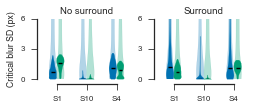

In [90]:
g = sns.FacetGrid(melted, 
                  col='surround', hue='patch_size',
                  palette=pal,
                  size=3.5/2)
g.map_dataframe(plot_violins, 'prior_critical_scale', alpha=0.3)
g.map_dataframe(plot_violins, 'critical_scale', alpha=1)
g.set(xticks=[2., 6., 10.],
      xticklabels=np.unique(melted['subj']))
# g.set(ylim=[0, 16])
# g.set(yticks=np.linspace(0, 16, num=3))
g.set(ylim=[0, 6])
g.set(yticks=np.linspace(0, 6, num=3))

titles = ["No surround",
          "Surround"]

for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

    
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Critical blur SD (px)')
sns.despine(offset=5, trim=True);

In [91]:
g.fig.get_size_inches()

array([ 3.5 ,  1.75])

In [92]:
g.fig.set_figwidth(3.5)
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_critical_scale.pdf'), bbox_inches='tight')

g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_critical_scale.svg'), bbox_inches='tight')

## Same for gain parameters

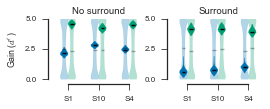

In [93]:
g = sns.FacetGrid(melted, 
                  col='surround', hue='patch_size',
                  palette=pal,                  
                  size=3.5/2)
g.map_dataframe(plot_violins, 'prior_alpha', alpha=0.3)
g.map_dataframe(plot_violins, 'alpha', alpha=1)
g.set(xticks=[2., 6., 10.],
      xticklabels=np.unique(melted['subj']))
g.set(yticks=np.linspace(0, 5, num=3))

titles = ["No surround",
          "Surround"]

for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# g.set(ylim=[0, 0.1])
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Gain ($d^\prime$)')
sns.despine(offset=5, trim=True);

In [94]:
g.fig.set_figwidth(3.5)
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_gain.pdf'), bbox_inches='tight')

g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_gain.svg'), bbox_inches='tight')


## Same for slope

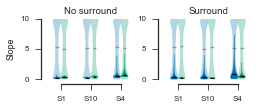

In [95]:
g = sns.FacetGrid(melted, 
                  col='surround', hue='patch_size',
                  palette=pal,                  
                  size=3.5/2)
g.map_dataframe(plot_violins, 'prior_beta', alpha=0.3)
g.map_dataframe(plot_violins, 'beta', alpha=1)
g.set(xticks=[2., 6., 10.],
      xticklabels=np.unique(melted['subj']))
g.set(yticks=np.linspace(0, 10, num=3))

titles = ["No surround",
          "Surround"]

for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# g.set(ylim=[0, 0.1])
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Slope')
sns.despine(offset=5, trim=True);

In [96]:
g.fig.set_figwidth(3.5)
print(g.fig.get_size_inches())
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_slope.pdf'), bbox_inches='tight')

g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_slope.svg'), bbox_inches='tight')


[ 3.5   1.75]


### Assemble multipanel figure using svgutils

See e.g. http://neuroscience.telenczuk.pl/?p=331

In [97]:
# create new SVG figure
fig = sg.SVGFigure("3.5in", "5.25in")

# load matpotlib-generated figures
fig1 = sg.fromfile(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_critical_scale.svg'))
fig2 = sg.fromfile(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                                model_name + '_params_gain.svg'))
fig3 = sg.fromfile(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                                model_name + '_params_slope.svg'))

# set size of composite based on panels (for some reason they aren't as saved):
w, h = fig1.get_size()
print(w, h)

# fig = sg.SVGFigure('514pt', '453pt')
# fig = sg.SVGFigure('514pt', '453pt')

# fig1.set_size(('7in', '2.33in'))
# fig2.set_size(('7in', '2.33in'))
# fig3.set_size(('7in', '2.33in'))

sep = 111
sep2 = 10

# get the plot objects
plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot3 = fig3.getroot()

# plot1.moveto(0, sep2)
plot2.moveto(0, sep)
plot3.moveto(0, sep*2)

# add text labels
txt1 = sg.TextElement(5, sep2, "A", size=12, weight="bold")
txt2 = sg.TextElement(5, sep + sep2, "B", size=12, weight="bold")
txt3 = sg.TextElement(5, sep * 2 + sep2, "C", size=12, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2, plot3])
fig.append([txt1, txt2, txt3])

# save generated SVG files
fig.save(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_params_multipanel.svg'))

255pt 110pt


I don't know why the size of the subplots is not respected. Will have to manually resize in inkscape.

# Difference scores for different surround conditions

To make the differences easier to quantify we could create difference plots.

In [98]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288000 entries, 0 to 287999
Data columns (total 6 columns):
subj          288000 non-null object
surround      288000 non-null object
patch_size    288000 non-null float64
sample        288000 non-null int64
param         288000 non-null object
value         288000 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 15.4+ MB


In [99]:
grouped = melted.groupby(['subj', 'patch_size', 'param', 'sample'], as_index=False)

In [100]:
def compute_diff(x):
    """compute the difference between 
    no surround and surround
    """
    a = x.loc[x['surround'] == 'blank', 'value']
    b = x.loc[x['surround'] == 'surround', 'value']
    return float(a.values - b.values)
    

In [101]:
diffs = grouped.apply(compute_diff)
diffs = diffs.reset_index(name='value')

In [102]:
def plot_zero(*args, **kwargs):
    data = kwargs.pop('data')
    plt.plot((0, 12), (0, 0), ls='-', color='0.7', alpha=0.6)
        

### Critical scale differences

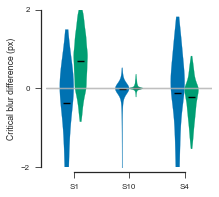

In [103]:
g = sns.FacetGrid(diffs, hue='patch_size',
                  palette=pal,
                  size=3)
g.map_dataframe(plot_zero)
g.map_dataframe(plot_violins, 'critical_scale', alpha=1)
g.set(xticks=[2., 6., 10.],
      xticklabels=np.unique(melted['subj']))
g.set(ylim=[-2, 2])
g.set(yticks=[-2, 0, 2])

# g.set(title='No surround - surround')
g.set_axis_labels('', 'Critical blur difference (px)')
sns.despine(offset=5, trim=True);

In [104]:
g.fig.set_figwidth(3.5/2)
print(g.fig.get_size_inches())
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_critical_scale_difference.pdf'), bbox_inches='tight')

g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_critical_scale_difference.svg'), bbox_inches='tight')


[ 1.75  3.  ]


### Gain differences


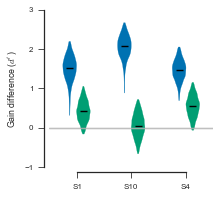

In [105]:
g = sns.FacetGrid(diffs, hue='patch_size',
                  palette=pal,
                  size=3)
g.map_dataframe(plot_zero)
g.map_dataframe(plot_violins, 'alpha', alpha=1)
g.set(xticks=[2., 6., 10.],
      xticklabels=np.unique(melted['subj']))
g.set(ylim=[-1, 3])
g.set(yticks=[-1, 0, 1, 2, 3])

# g.set(title='No surround - surround')
g.set_axis_labels('', 'Gain difference ($d^\prime$)')
sns.despine(offset=5, trim=True);

In [106]:
g.fig.set_figwidth(3.5/2)
print(g.fig.get_size_inches())
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_gain_difference.pdf'), bbox_inches='tight')

g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_gain_difference.svg'), bbox_inches='tight')


[ 1.75  3.  ]


### Slope difference

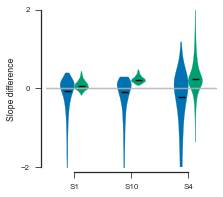

In [107]:
g = sns.FacetGrid(diffs, hue='patch_size',
                  palette=pal,
                  size=3)
g.map_dataframe(plot_zero)
g.map_dataframe(plot_violins, 'beta', alpha=1)
g.set(xticks=[2., 6., 10.],
      xticklabels=np.unique(melted['subj']))
g.set(ylim=[-2, 2])
g.set(yticks=[-2, 0, 2])

# g.set(title='No surround - surround')
g.set_axis_labels('', 'Slope difference')
sns.despine(offset=5, trim=True);

In [108]:
g.fig.set_figwidth(3.5/2)
print(g.fig.get_size_inches())
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_slope_difference.pdf'), bbox_inches='tight')

g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_slope_difference.svg'), bbox_inches='tight')


[ 1.75  3.  ]


## Export point estimates to csv

For ANOVA-style analysis in JASP

In [109]:
melted.head()

,subj,surround,patch_size,sample,param,value
0,S1,blank,0.74,0,alpha,2.094182
1,S10,blank,0.74,0,alpha,2.922146
2,S4,blank,0.74,0,alpha,2.374117
3,S1,surround,0.74,0,alpha,0.828849
4,S10,surround,0.74,0,alpha,0.564715


In [110]:
# reduce mcmc samples to point estimates:
pe = melted.groupby(['subj', 'surround', 'patch_size', 'param'], as_index=False).value.agg({'median': np.median,
                                                                                            'mean': np.mean})

# not interested in priors:
mask = (pe['param'] != 'prior_alpha') & \
       (pe['param'] != 'prior_beta') & \
       (pe['param'] != 'prior_critical_scale')
pe = pe.loc[mask, :]

In [111]:
pe.head()

,subj,surround,patch_size,param,mean,median
0,S1,blank,0.74,alpha,2.159685,2.145795
1,S1,blank,0.74,beta,0.301054,0.240188
2,S1,blank,0.74,critical_scale,0.852001,0.730117
6,S1,blank,5.95,alpha,4.556318,4.568970
7,S1,blank,5.95,beta,0.336872,0.308190


In [112]:
# convert patch size to string:
pe['patch_size'] = pe['patch_size'].astype(str)

In [113]:
# pivot the frame around to have one subject per row:
out = pd.pivot_table(pe, 
                     index=['subj'], 
                     columns=['param', 'surround', 'patch_size'], 
                     values=['median', 'mean'])

# rename column names (from https://stackoverflow.com/questions/14507794/python-pandas-how-to-flatten-a-hierarchical-index-in-columns)
out.columns = ['_'.join(col).strip() for col in out.columns.values]
out

,mean_alpha_blank_0.74,mean_alpha_blank_5.95,mean_alpha_surround_0.74,mean_alpha_surround_5.95,mean_beta_blank_0.74,mean_beta_blank_5.95,mean_beta_surround_0.74,mean_beta_surround_5.95,mean_critical_scale_blank_0.74,mean_critical_scale_blank_5.95,...,median_alpha_surround_0.74,median_alpha_surround_5.95,median_beta_blank_0.74,median_beta_blank_5.95,median_beta_surround_0.74,median_beta_surround_5.95,median_critical_scale_blank_0.74,median_critical_scale_blank_5.95,median_critical_scale_surround_0.74,median_critical_scale_surround_5.95
subj,,,,,,,,,,,,,,,,,,,,,
S1,2.159685,4.556318,0.686686,4.131695,0.301054,0.336872,0.719434,0.252216,0.852001,1.492571,...,0.618829,4.134347,0.240188,0.308190,0.305957,0.231004,0.730117,1.614004,1.189266,0.763979
S10,2.818047,4.221743,0.801337,4.167530,0.276714,0.449505,0.763847,0.219004,0.155760,0.120009,...,0.745883,4.158384,0.266778,0.431211,0.367960,0.214759,0.053248,0.060345,0.065542,0.034426
S4,2.464526,4.511112,1.021107,3.963723,0.765040,1.048707,1.566807,0.720184,1.144818,0.844604,...,0.994433,3.946145,0.497183,0.739609,0.795189,0.485900,1.108465,0.916415,1.136208,1.161250


In [114]:
# save to csv for analysis in JASP:
out.to_csv(os.path.join(top_dir, 'results', 
                        'experiment-{}'.format(experiment_num), 'point_estimates.csv'))

## How does the population mu change from prior to posterior?

With only four subjects, probably not much.

In [115]:
pop_param_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 0 to 3
Data columns (total 9 columns):
patch_size                 16000 non-null float64
surround                   16000 non-null object
sample                     16000 non-null int64
mu_alpha                   16000 non-null float64
mu_beta                    16000 non-null float64
mu_critical_scale          16000 non-null float64
prior_mu_alpha             16000 non-null float64
prior_mu_beta              16000 non-null float64
prior_mu_critical_scale    16000 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.2+ MB


In [116]:
pop_melted = pd.melt(pop_param_df, id_vars=['surround', 'patch_size', 'sample'],
                 var_name='param',
                 value_name='value')
pop_melted.head()

,surround,patch_size,sample,param,value
0,blank,0.74,0,mu_alpha,2.092845
1,surround,0.74,0,mu_alpha,0.922499
2,blank,5.95,0,mu_alpha,4.641280
3,surround,5.95,0,mu_alpha,3.886258
4,blank,0.74,1,mu_alpha,2.475049


In [117]:
np.unique(pop_melted['param'])

array(['mu_alpha', 'mu_beta', 'mu_critical_scale', 'prior_mu_alpha',
       'prior_mu_beta', 'prior_mu_critical_scale'], dtype=object)

In [118]:
def plot_pop_violins(*args, **kwargs):
    param, = args
    data = kwargs.pop('data')
    # select desired parameter:
    data = data.loc[data['param'] == param, :]
    
    if np.any(data['patch_size'] == 0.74):
        this_pos = np.array([- 0.5])
    else:
        this_pos = np.array([+ 0.5])

    # crop data to 95% middle:
    x = data.loc[:, 'value'].values
    x = x[x >= np.percentile(x, 2.5)]
    x = x[x <= np.percentile(x, 97.5)]

    # stupid violinplot color setting:
    # https://stackoverflow.com/questions/26291479/changing-the-color-of-matplotlibs-violin-plots
    result = plt.violinplot(x, this_pos, 
                            showmeans=False,
                            showmedians=True,
                            showextrema=False,
                            widths=1.)
    for patch in result['bodies']: 
        patch.set_color(kwargs['color'])
        patch.set_label(kwargs['label'])
        patch.set_alpha(kwargs['alpha'])

    result['cmedians'].set_color('k')
    result['cmedians'].set_alpha(kwargs['alpha'])

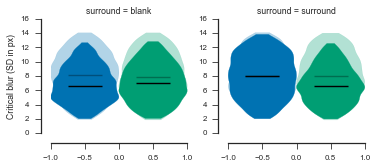

In [119]:
g = sns.FacetGrid(pop_melted, 
                  col='surround', hue='patch_size',
                  palette=pal,                  
                  size=2.5)
g.map_dataframe(plot_pop_violins, 'prior_mu_critical_scale', alpha=0.3)
g.map_dataframe(plot_pop_violins, 'mu_critical_scale', alpha=1)
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Critical blur (SD in px)')
sns.despine(offset=10, trim=True);

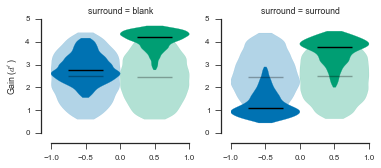

In [120]:
g = sns.FacetGrid(pop_melted, 
                  col='surround', hue='patch_size',
                  palette=pal,                  
                  size=2.5)
g.map_dataframe(plot_pop_violins, 'prior_mu_alpha', alpha=0.3)
g.map_dataframe(plot_pop_violins, 'mu_alpha', alpha=1)
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Gain ($d^\prime$)')
sns.despine(offset=10, trim=True);

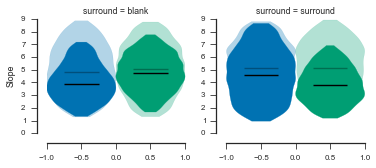

In [121]:
g = sns.FacetGrid(pop_melted, 
                  col='surround', hue='patch_size',
                  palette=pal,                  
                  size=2.5)
g.map_dataframe(plot_pop_violins, 'prior_mu_beta', alpha=0.3)
g.map_dataframe(plot_pop_violins, 'mu_beta', alpha=1)
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Slope')
sns.despine(offset=10, trim=True);

# Performance variation for individual images

Pooling all data across observers, how much does performance vary over images?

- for largest and smallest stimulus level tested
- for surround cases, and patch sizes in blur?

In [122]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5952 entries, 0 to 6099
Data columns (total 22 columns):
surround         5952 non-null object
oddball          5952 non-null int64
im_code          5952 non-null object
target_loc       5952 non-null int64
jitter_1         5952 non-null float64
jitter_2         5952 non-null float64
jitter_3         5952 non-null float64
subj             5952 non-null object
session          5952 non-null int64
eccent           5952 non-null int64
patch_size_px    5952 non-null int64
blur_sigma       5952 non-null float64
test_location    5952 non-null object
rand_seed        5952 non-null float64
trial            5952 non-null int64
response         5952 non-null object
rt               5940 non-null float64
correct          5940 non-null float64
eye_invalid      5948 non-null float64
eye_sd_deg       5903 non-null float64
time_invalid     5948 non-null float64
patch_size       5952 non-null float64
dtypes: float64(11), int64(6), object(5)
memory usag

## Images ordered *within* groups of size and surround condition

In [123]:
# bin into groups, create image code based on performance:

processed.loc[(processed['blur_sigma']<=5.), 'blur_cat'] = 'low'
processed.loc[(processed['blur_sigma']>=8.), 'blur_cat'] = 'high'

def sort_ims(cell):
    cell = helpers.binomial_binning(cell, 
                                    ['im_code', 'surround', 'patch_size', 'blur_cat'], 
                                    rule_of_succession=True)
    # sort cells by average performance across conditions, assign number
    means = cell.groupby(['im_code']).mean()
    means.loc[:, 'im_code'] = means.index  # need to stick im_code back in. dumb.
    means = means.sort(columns='prop_corr')
    means.loc[:, 'im_num'] = np.arange(len(means))

    # cut out irrelevant cols:
    means = means.loc[:, ['im_code', 'im_num']]
    
    # re-merge im_num label with larger dataframe:
    merged = pd.merge(cell, means, on=['im_code'])
    return merged
    
grouped = processed.groupby(['surround', 'patch_size'])
plot_dat = grouped.apply(sort_ims)
plot_dat.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 800 entries, (blank, 0.74, 0) to (surround, 5.95, 199)
Data columns (total 12 columns):
im_code        800 non-null object
surround       800 non-null object
patch_size     800 non-null float64
blur_cat       800 non-null object
n_trials       800 non-null float64
n_successes    800 non-null float64
prop_corr      800 non-null float64
ci_min         800 non-null float64
ci_max         800 non-null float64
error_min      800 non-null float64
error_max      800 non-null float64
im_num         800 non-null int64
dtypes: float64(8), int64(1), object(3)
memory usage: 79.9+ KB


/Users/tomwallis/miniconda3/envs/default/lib/python3.4/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tomwallis/miniconda3/envs/default/lib/python3.4/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [124]:
# define plot funs
def plot_chance(*args, **kwargs):
    data = kwargs.pop('data')
    plt.plot((0, 99), (0.33, 0.33), ls='--', color='0.7')
    
def plot_errors(*args, **kwargs):
    data = kwargs.pop('data')
    x_col, y_col = args
    errors = np.vstack([data.loc[:, 'error_min'], 
                        data.loc[:, 'error_max']])

    plt.errorbar(data.loc[:, x_col], 
                 data.loc[:, y_col], 
                 yerr=errors,
                 **kwargs);        

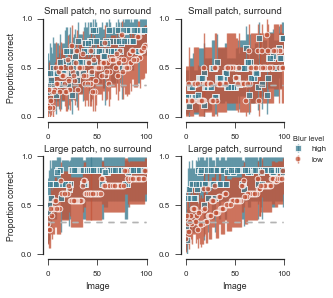

In [125]:
pal = sns.diverging_palette(220, 20, n=2)

g = sns.FacetGrid(plot_dat, col='surround', row='patch_size', hue='blur_cat', hue_kws={'marker': ['s', 'o']},
                  palette=pal,
                  size=2)
g.map_dataframe(plot_errors, 'im_num', 'prop_corr',
                linestyle='none', alpha=0.75,
                mec='w', mew=1, capsize=0)
g.map_dataframe(plot_chance)

# aesthetics:
g.set_axis_labels('Image', 'Proportion correct')
g.set(xticks=np.linspace(0, 100, num=3), yticks=np.linspace(0, 1, num=3))
g.add_legend(title='Blur level')

# set shorter titles for facets:
titles = ["Small patch, no surround",
          "Small patch, surround",
          "Large patch, no surround",
          "Large patch, surround"]

for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

g.fig.subplots_adjust(wspace=0.4, hspace=0.4)
sns.despine(offset=5, trim=True);

In [126]:
g.fig.set_figwidth(5.5)
print(g.fig.get_size_inches())
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       'performance_by_images_sorted_within_cond.pdf'), bbox_inches='tight')

g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       'performance_by_images_sorted_within_cond.svg'), bbox_inches='tight')

[ 5.5  4. ]


### Which images are easiest in the large patch condition?


In [127]:
mask = (plot_dat['patch_size'] == 5.95) & \
       (plot_dat['surround'] == 'blank') & \
       (plot_dat['blur_cat'] == 'low')
large_patch_subset = plot_dat.loc[mask, :].copy()

# easiest in large patch size:
large_patch_subset.sort(columns='prop_corr', ascending=False).head()

im_code surround  \
surround patch_size                                                           
blank    5.95       135                                i2246755161    blank   
                    79                                 i1771710966    blank   
                    53                                 i1464437389    blank   
                    161                                i2292751124    blank   
                    171  i30may05_static_street_cambridge_p1010717    blank   

                         patch_size blur_cat  n_trials  n_successes  \
surround patch_size                                                   
blank    5.95       135        5.95      low        13           11   
                    79         5.95      low        13           11   
                    53         5.95      low        13           11   
                    161        5.95      low        13           11   
                    171        5.95      low        13           11   

                         prop_corr    ci_min    ci_max  error_min  error_max  \
surround patch_size                                                            
blank    5.95       135   0.846154  0.615204  0.979137    0.23095   0.132984   
                    79    0.846154  0.615204  0.979137    0.23095   0.132984   
                    53    0.846154  0.615204  0.979137    0.23095   0.132984   
                    161   0.846154  0.615204  0.979137    0.23095   0.132984   
                    171   0.846154  0.615204  0.979137    0.23095   0.132984   

                         im_num  
surround patch_size              
blank    5.95       135      80  
                    79       99  
                    53       79  
                    161      98  
                    171      78

In [128]:
# hardest in large patch size:
large_patch_subset.sort(columns='prop_corr', ascending=True).head()

im_code surround  patch_size blur_cat  n_trials  \
surround patch_size                                                            
blank    5.95       7     i102423191    blank        5.95      low        12   
                    145  i2281390450    blank        5.95      low        12   
                    151  i2289458290    blank        5.95      low        13   
                    91   i1918259724    blank        5.95      low        13   
                    157  i2290794919    blank        5.95      low        13   

                         n_successes  prop_corr    ci_min    ci_max  \
surround patch_size                                                   
blank    5.95       7              3   0.250000  0.060218  0.517756   
                    145            3   0.250000  0.060218  0.517756   
                    151            4   0.307692  0.099246  0.571858   
                    91             5   0.384615  0.151652  0.651124   
                    157            6   0.461538  0.210945  0.723330   

                         error_min  error_max  im_num  
surround patch_size                                    
blank    5.95       7     0.189782   0.267756       1  
                    145   0.189782   0.267756       2  
                    151   0.208446   0.264166       0  
                    91    0.232963   0.266509       4  
                    157   0.250594   0.261792       3

## Relationship between performance and saliency

In [129]:
# load image data:
im_dat = pd.read_csv(os.path.join(top_dir, 'stimuli', 'experiment-9', 'final_ims', 'patch_info.csv'), index_col=False)
im_dat.rename(columns={'filename': 'im_code'}, inplace=True)
im_subset = im_dat.loc[:, ['im_code', 'middle_rms', 'sal_mid_mean']]
im_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 3 columns):
im_code         614 non-null object
middle_rms      614 non-null float64
sal_mid_mean    614 non-null float64
dtypes: float64(2), object(1)
memory usage: 19.2+ KB


In [130]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5952 entries, 0 to 6099
Data columns (total 23 columns):
surround         5952 non-null object
oddball          5952 non-null int64
im_code          5952 non-null object
target_loc       5952 non-null int64
jitter_1         5952 non-null float64
jitter_2         5952 non-null float64
jitter_3         5952 non-null float64
subj             5952 non-null object
session          5952 non-null int64
eccent           5952 non-null int64
patch_size_px    5952 non-null int64
blur_sigma       5952 non-null float64
test_location    5952 non-null object
rand_seed        5952 non-null float64
trial            5952 non-null int64
response         5952 non-null object
rt               5940 non-null float64
correct          5940 non-null float64
eye_invalid      5948 non-null float64
eye_sd_deg       5903 non-null float64
time_invalid     5948 non-null float64
patch_size       5952 non-null float64
blur_cat         5952 non-null object
dtypes: float6

In [131]:
# binomial proportions for each image, across subjects, blurs and surround, in each patch size:
image_perf = helpers.binomial_binning(processed, 
                                      ['im_code', 'patch_size'], 
                                      rule_of_succession=True)
image_perf.head()

,im_code,patch_size,n_trials,n_successes,prop_corr,ci_min,ci_max,error_min,error_max
0,i05june05_static_street_boston_p1010764,0.74,29,11,0.379310,0.215043,0.559350,0.164268,0.180039
1,i05june05_static_street_boston_p1010806,5.95,32,25,0.781250,0.625268,0.904058,0.155982,0.122808
2,i05june05_static_street_boston_p1010808,0.74,29,18,0.620690,0.440650,0.784957,0.180039,0.164268
3,i1000978947,5.95,34,27,0.794118,0.645399,0.910196,0.148718,0.116078
4,i1007068829,0.74,30,15,0.500000,0.325315,0.674685,0.174685,0.174685


In [132]:
image_perf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 9 columns):
im_code        200 non-null object
patch_size     200 non-null float64
n_trials       200 non-null float64
n_successes    200 non-null float64
prop_corr      200 non-null float64
ci_min         200 non-null float64
ci_max         200 non-null float64
error_min      200 non-null float64
error_max      200 non-null float64
dtypes: float64(8), object(1)
memory usage: 15.6+ KB


In [133]:
# merge in the saliency values on image code (drops one case, not sure why):
with_sal = pd.merge(image_perf, im_subset, on='im_code')
with_sal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 198
Data columns (total 11 columns):
im_code         199 non-null object
patch_size      199 non-null float64
n_trials        199 non-null float64
n_successes     199 non-null float64
prop_corr       199 non-null float64
ci_min          199 non-null float64
ci_max          199 non-null float64
error_min       199 non-null float64
error_max       199 non-null float64
middle_rms      199 non-null float64
sal_mid_mean    199 non-null float64
dtypes: float64(10), object(1)
memory usage: 18.7+ KB


In [134]:
# z-score empirical saliency:
def norm_func(dat):
    dat.loc[:, 'sal_mid_mean_normed'] = ((dat.loc[:, 'sal_mid_mean'] - 
                                          dat.loc[:, 'sal_mid_mean'].mean()) / 
                                          dat.loc[:, 'sal_mid_mean'].std())
    return dat

with_sal = with_sal.groupby(['patch_size']).apply(norm_func)
with_sal['sal_mid_mean_normed'].describe()

count    1.990000e+02
mean     9.819058e-17
std      9.974716e-01
min     -1.169828e+00
25%     -6.829373e-01
50%     -3.008989e-01
75%      3.422445e-01
max      5.131057e+00
Name: sal_mid_mean_normed, dtype: float64

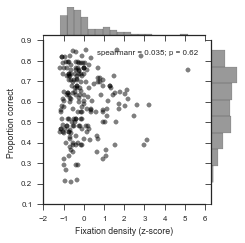

In [135]:
# plot correlation between saliency and proportion correct:
g = sns.jointplot('sal_mid_mean_normed', 'prop_corr', data=with_sal,
                  stat_func=spearmanr,
                  size=3.5, color='black', alpha=0.5)
g.set_axis_labels('Fixation density (z-score)', 'Proportion correct');             

In [136]:
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       'explore_saliency.pdf'), bbox_inches='tight')